In [1]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp
import numpy as onp
from encoding_information.image_utils import *
from encoding_information.information_estimation import *


2023-12-11 08:05:53.108638: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 08:05:53.869206: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

In [2]:
# load MNIST
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# concatenate train and test
data = np.concatenate([x_train, x_test], axis=0)

In [3]:
def make_3x3_tiled_random():
    """
    Make a random, 3x3 tiled MNIST image
    """
    # pick 9 random images
    inds = onp.random.choice(data.shape[0], size=9, replace=False)
    images = data[inds]
    
    # tile them
    tiled = np.concatenate([np.concatenate(images[:3], axis=1),
                            np.concatenate(images[3:6], axis=1),
                            np.concatenate(images[6:], axis=1)], axis=0)
    return tiled

In [4]:
# Generate dataset of 15k random 3x3 tiled MNIST images
N = 15000
images = []
for i in tqdm(range(N)):
    tiled = make_3x3_tiled_random()
    images.append(tiled)

images = np.stack(images).astype(np.float32)

  0%|          | 0/15000 [00:00<?, ?it/s]

100%|██████████| 15000/15000 [01:19<00:00, 188.66it/s]


In [5]:
# add background
images += 10

In [11]:
# duplicate the data 10x
images = np.tile(images, (10, 1, 1))

In [6]:
# add unifor 0 1 noise
images += np.array(onp.random.uniform(size=images.shape, low=0, high=1))

In [6]:
# add Gaussian noise
images += np.array(onp.random.normal(size=images.shape, loc=0, scale=1))

In [7]:
cropped_mnist_unconvolved = images[:, 28:56, 28:56]

In [8]:
from scipy.ndimage import gaussian_filter
from jax.scipy.signal import convolve2d
from jax import vmap

# make a gaussian kernel with std = 1
gaussian_kernel = onp.zeros((28, 28))
gaussian_kernel[14, 14] = 1
gaussian_kernel = gaussian_filter(gaussian_kernel, sigma=1)

gaussian_kernel = gaussian_kernel / gaussian_kernel.sum()

# use jax to do a fast convolution of each image with the gaussian kernel
batch_convolve = vmap(lambda a, b: convolve2d(a,b, mode='valid'), in_axes=(0, None))


batch_size = 100
num_batches = images.shape[0] // batch_size

# perform convolution in batches
cropped_mnist_convolved = []
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    batch_images = images[start_idx:end_idx]
    batch_convolved = batch_convolve(batch_images, gaussian_kernel)
    cropped_mnist_convolved.append(batch_convolved)

# concatenate the convolved images from all batches
cropped_mnist_convolved = np.concatenate(cropped_mnist_convolved, axis=0)[:, 14:42, 14:42]

  0%|          | 0/150 [00:00<?, ?it/s]2023-12-11 08:07:27.797434: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng1{k2=2,k3=0} for conv (f64[100,1,57,57]{3,2,1,0}, u8[0]{0}) custom-call(f64[100,1,84,84]{3,2,1,0}, f64[1,1,28,28]{3,2,1,0}), window={size=28x28}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2023-12-11 08:07:28.372151: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.57480573s
Trying algorithm eng1{k2=2,k3=0} for conv (f64[100,1,57,57]{3,2,1,0}, u8[0]{0}) custom-call(f64[100,1,84,84]{3,2,1,0}, f64[1,1,28,28]{3,2,1,0}), window={size=28x28}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2023-12-11 08:07:29.684782: E externa

In [9]:
# add detection noise (Gaussian)
cropped_mnist_convolved = add_noise(cropped_mnist_convolved, gaussian_sigma=8)
cropped_mnist_unconvolved = add_noise(cropped_mnist_unconvolved, gaussian_sigma=8)



In [8]:
# add detection noise (Poisson)
cropped_mnist_convolved = add_noise(cropped_mnist_convolved)
cropped_mnist_unconvolved = add_noise(cropped_mnist_unconvolved)

44.801006957650856
44.71774567162891


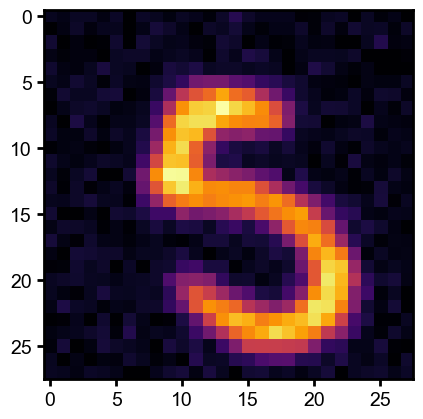

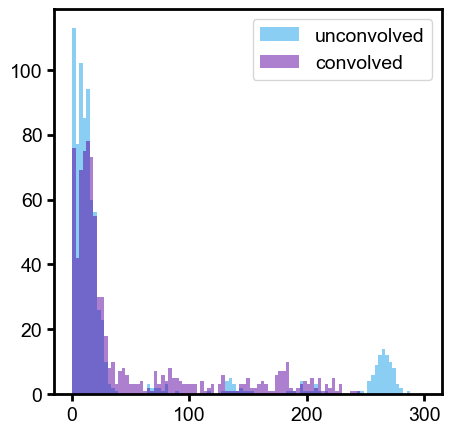

In [10]:
# plot a cropped mnist convolved image
plt.imshow(cropped_mnist_convolved[0], cmap='inferno')

# show image histograms
plt.figure(figsize=(5, 5))
bins = np.linspace(0, 300, 100)
plt.hist(cropped_mnist_unconvolved[0].flatten(), bins=bins, alpha=0.5, label='unconvolved')
plt.hist(cropped_mnist_convolved[0].flatten(), bins=bins, alpha=0.5, label='convolved') 
plt.legend()

# make sure the energy is the same
print(cropped_mnist_unconvolved[:50].mean())
print(cropped_mnist_convolved[:50].mean())

In [11]:
from encoding_information.models.pixel_cnn import PixelCNN

# train pixelcnns on both the convolved and unconvolved images

pixel_cnn_unconv = PixelCNN()
val_loss_unconv = pixel_cnn_unconv.fit(cropped_mnist_unconvolved, verbose=True, add_uniform_noise=True, do_lr_decay=True,
                                       max_epochs=500, patience=200)

pixel_cnn_conv = PixelCNN()
val_loss_conv = pixel_cnn_conv.fit(cropped_mnist_convolved, verbose=True, add_uniform_noise=True, do_lr_decay=True,
                                   max_epochs=500, patience=200)

2023-12-11 08:07:43.630029: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Initial validation NLL: 7.63


Epoch 1: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 1: validation NLL: 3.73


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 29.74it/s]


Epoch 2: validation NLL: 3.66


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 30.78it/s]


Epoch 3: validation NLL: 3.65


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 30.78it/s]


Epoch 4: validation NLL: 3.61


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 30.80it/s]


Epoch 5: validation NLL: 3.61


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 30.84it/s]


Epoch 6: validation NLL: 3.59


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 30.77it/s]


Epoch 7: validation NLL: 3.59


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 30.95it/s]


Epoch 8: validation NLL: 3.58


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 30.86it/s]


Epoch 9: validation NLL: 3.58


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 29.75it/s]


Epoch 10: validation NLL: 3.58


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 29.89it/s]


Epoch 11: validation NLL: 3.58


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 29.88it/s]


Epoch 12: validation NLL: 3.57


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 29.80it/s]


Epoch 13: validation NLL: 3.57


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 29.75it/s]


Epoch 14: validation NLL: 3.57


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 29.49it/s]


Epoch 15: validation NLL: 3.57


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 29.54it/s]


Epoch 16: validation NLL: 3.57


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 29.58it/s]


Epoch 17: validation NLL: 3.57


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 29.43it/s]


Epoch 18: validation NLL: 3.57


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 29.80it/s]


Epoch 19: validation NLL: 3.57


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 29.77it/s]


Epoch 20: validation NLL: 3.57


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 29.96it/s]


Epoch 21: validation NLL: 3.57


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 29.44it/s]


Epoch 22: validation NLL: 3.57


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 29.80it/s]


Epoch 23: validation NLL: 3.57


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 30.78it/s]


Epoch 24: validation NLL: 3.56


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 30.65it/s]


Epoch 25: validation NLL: 3.57


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 30.79it/s]


Epoch 26: validation NLL: 3.57


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 30.95it/s]


Epoch 27: validation NLL: 3.56


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 30.81it/s]


Epoch 28: validation NLL: 3.56


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 30.62it/s]


Epoch 29: validation NLL: 3.57


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 30.99it/s]


Epoch 30: validation NLL: 3.56


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 30.89it/s]


Epoch 31: validation NLL: 3.56


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 30.57it/s]


Epoch 32: validation NLL: 3.57


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 30.97it/s]


Epoch 33: validation NLL: 3.56


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 30.60it/s]


Epoch 34: validation NLL: 3.56


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 30.99it/s]


Epoch 35: validation NLL: 3.56


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 30.91it/s]


Epoch 36: validation NLL: 3.57


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 31.10it/s]


Epoch 37: validation NLL: 3.56


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 29.49it/s]


Epoch 38: validation NLL: 3.56


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 29.74it/s]


Epoch 39: validation NLL: 3.56


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 29.63it/s]


Epoch 40: validation NLL: 3.56


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 29.54it/s]


Epoch 41: validation NLL: 3.56


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 29.58it/s]


Epoch 42: validation NLL: 3.56


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 29.61it/s]


Epoch 43: validation NLL: 3.56


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 29.60it/s]


Epoch 44: validation NLL: 3.56


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 29.57it/s]


Epoch 45: validation NLL: 3.56


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 29.59it/s]


Epoch 46: validation NLL: 3.56


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 29.67it/s]


Epoch 47: validation NLL: 3.56


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 29.69it/s]


Epoch 48: validation NLL: 3.56


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 29.80it/s]


Epoch 49: validation NLL: 3.56


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 29.66it/s]


Epoch 50: validation NLL: 3.56


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 29.36it/s]


Epoch 51: validation NLL: 3.56


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 29.52it/s]


Epoch 52: validation NLL: 3.56


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 29.56it/s]


Epoch 53: validation NLL: 3.56


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 29.95it/s]


Epoch 54: validation NLL: 3.56


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 29.61it/s]


Epoch 55: validation NLL: 3.56


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 29.52it/s]


Epoch 56: validation NLL: 3.56


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 30.75it/s]


Epoch 57: validation NLL: 3.56


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 30.84it/s]


Epoch 58: validation NLL: 3.56


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 30.84it/s]


Epoch 59: validation NLL: 3.56


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 30.79it/s]


Epoch 60: validation NLL: 3.56


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 30.97it/s]


Epoch 61: validation NLL: 3.56


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 30.81it/s]


Epoch 62: validation NLL: 3.56


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 30.87it/s]


Epoch 63: validation NLL: 3.56


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 30.90it/s]


Epoch 64: validation NLL: 3.56


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 30.97it/s]


Epoch 65: validation NLL: 3.56


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 30.61it/s]


Epoch 66: validation NLL: 3.56


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 30.82it/s]


Epoch 67: validation NLL: 3.56


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 30.72it/s]


Epoch 68: validation NLL: 3.56


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 29.72it/s]


Epoch 69: validation NLL: 3.56


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 29.72it/s]


Epoch 70: validation NLL: 3.56


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 29.74it/s]


Epoch 71: validation NLL: 3.56


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 29.49it/s]


Epoch 72: validation NLL: 3.56


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 29.81it/s]


Epoch 73: validation NLL: 3.56


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 29.39it/s]


Epoch 74: validation NLL: 3.56


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 29.84it/s]


Epoch 75: validation NLL: 3.56


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 29.52it/s]


Epoch 76: validation NLL: 3.56


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 29.74it/s]


Epoch 77: validation NLL: 3.56


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 29.67it/s]


Epoch 78: validation NLL: 3.56


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 29.75it/s]


Epoch 79: validation NLL: 3.56


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 29.60it/s]


Epoch 80: validation NLL: 3.56


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 29.77it/s]


Epoch 81: validation NLL: 3.56


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 29.57it/s]


Epoch 82: validation NLL: 3.56


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 29.54it/s]


Epoch 83: validation NLL: 3.56


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 29.79it/s]


Epoch 84: validation NLL: 3.56


Epoch 85: 100%|██████████| 100/100 [00:03<00:00, 30.52it/s]


Epoch 85: validation NLL: 3.56


Epoch 86: 100%|██████████| 100/100 [00:03<00:00, 30.79it/s]


Epoch 86: validation NLL: 3.56


Epoch 87: 100%|██████████| 100/100 [00:03<00:00, 30.69it/s]


Epoch 87: validation NLL: 3.56


Epoch 88: 100%|██████████| 100/100 [00:03<00:00, 30.43it/s]


Epoch 88: validation NLL: 3.56


Epoch 89: 100%|██████████| 100/100 [00:03<00:00, 30.57it/s]


Epoch 89: validation NLL: 3.56


Epoch 90: 100%|██████████| 100/100 [00:03<00:00, 30.96it/s]


Epoch 90: validation NLL: 3.56


Epoch 91: 100%|██████████| 100/100 [00:03<00:00, 30.72it/s]


Epoch 91: validation NLL: 3.56


Epoch 92: 100%|██████████| 100/100 [00:03<00:00, 30.83it/s]


Epoch 92: validation NLL: 3.56


Epoch 93: 100%|██████████| 100/100 [00:03<00:00, 30.83it/s]


Epoch 93: validation NLL: 3.56


Epoch 94: 100%|██████████| 100/100 [00:03<00:00, 30.56it/s]


Epoch 94: validation NLL: 3.56


Epoch 95: 100%|██████████| 100/100 [00:03<00:00, 30.68it/s]


Epoch 95: validation NLL: 3.56


Epoch 96: 100%|██████████| 100/100 [00:03<00:00, 30.58it/s]


Epoch 96: validation NLL: 3.56


Epoch 97: 100%|██████████| 100/100 [00:03<00:00, 30.78it/s]


Epoch 97: validation NLL: 3.56


Epoch 98: 100%|██████████| 100/100 [00:03<00:00, 30.85it/s]


Epoch 98: validation NLL: 3.56


Epoch 99: 100%|██████████| 100/100 [00:03<00:00, 30.70it/s]


Epoch 99: validation NLL: 3.56


Epoch 100: 100%|██████████| 100/100 [00:03<00:00, 30.61it/s]


Epoch 100: validation NLL: 3.56


Epoch 101: 100%|██████████| 100/100 [00:03<00:00, 30.78it/s]


Epoch 101: validation NLL: 3.56


Epoch 102: 100%|██████████| 100/100 [00:03<00:00, 31.05it/s]


Epoch 102: validation NLL: 3.56


Epoch 103: 100%|██████████| 100/100 [00:03<00:00, 30.62it/s]


Epoch 103: validation NLL: 3.56


Epoch 104: 100%|██████████| 100/100 [00:03<00:00, 30.83it/s]


Epoch 104: validation NLL: 3.56


Epoch 105: 100%|██████████| 100/100 [00:03<00:00, 30.98it/s]


Epoch 105: validation NLL: 3.56


Epoch 106: 100%|██████████| 100/100 [00:03<00:00, 30.92it/s]


Epoch 106: validation NLL: 3.56


Epoch 107: 100%|██████████| 100/100 [00:03<00:00, 29.82it/s]


Epoch 107: validation NLL: 3.56


Epoch 108: 100%|██████████| 100/100 [00:03<00:00, 29.72it/s]


Epoch 108: validation NLL: 3.56


Epoch 109: 100%|██████████| 100/100 [00:03<00:00, 29.67it/s]


Epoch 109: validation NLL: 3.56


Epoch 110: 100%|██████████| 100/100 [00:03<00:00, 29.79it/s]


Epoch 110: validation NLL: 3.56


Epoch 111: 100%|██████████| 100/100 [00:03<00:00, 29.68it/s]


Epoch 111: validation NLL: 3.56


Epoch 112: 100%|██████████| 100/100 [00:03<00:00, 29.70it/s]


Epoch 112: validation NLL: 3.56


Epoch 113: 100%|██████████| 100/100 [00:03<00:00, 29.62it/s]


Epoch 113: validation NLL: 3.56


Epoch 114: 100%|██████████| 100/100 [00:03<00:00, 29.62it/s]


Epoch 114: validation NLL: 3.56


Epoch 115: 100%|██████████| 100/100 [00:03<00:00, 29.57it/s]


Epoch 115: validation NLL: 3.56


Epoch 116: 100%|██████████| 100/100 [00:03<00:00, 29.72it/s]


Epoch 116: validation NLL: 3.56


Epoch 117: 100%|██████████| 100/100 [00:03<00:00, 29.82it/s]


Epoch 117: validation NLL: 3.56


Epoch 118: 100%|██████████| 100/100 [00:03<00:00, 29.69it/s]


Epoch 118: validation NLL: 3.56


Epoch 119: 100%|██████████| 100/100 [00:03<00:00, 30.70it/s]


Epoch 119: validation NLL: 3.56


Epoch 120: 100%|██████████| 100/100 [00:03<00:00, 29.50it/s]


Epoch 120: validation NLL: 3.57


Epoch 121: 100%|██████████| 100/100 [00:03<00:00, 31.00it/s]


Epoch 121: validation NLL: 3.57


Epoch 122: 100%|██████████| 100/100 [00:03<00:00, 30.60it/s]


Epoch 122: validation NLL: 3.57


Epoch 123: 100%|██████████| 100/100 [00:03<00:00, 30.70it/s]


Epoch 123: validation NLL: 3.56


Epoch 124: 100%|██████████| 100/100 [00:03<00:00, 30.79it/s]


Epoch 124: validation NLL: 3.57


Epoch 125: 100%|██████████| 100/100 [00:03<00:00, 30.79it/s]


Epoch 125: validation NLL: 3.57


Epoch 126: 100%|██████████| 100/100 [00:03<00:00, 30.48it/s]


Epoch 126: validation NLL: 3.57


Epoch 127: 100%|██████████| 100/100 [00:03<00:00, 30.61it/s]


Epoch 127: validation NLL: 3.57


Epoch 128: 100%|██████████| 100/100 [00:03<00:00, 30.78it/s]


Epoch 128: validation NLL: 3.57


Epoch 129: 100%|██████████| 100/100 [00:03<00:00, 30.64it/s]


Epoch 129: validation NLL: 3.57


Epoch 130: 100%|██████████| 100/100 [00:03<00:00, 30.73it/s]


Epoch 130: validation NLL: 3.57


Epoch 131: 100%|██████████| 100/100 [00:03<00:00, 30.68it/s]


Epoch 131: validation NLL: 3.57


Epoch 132: 100%|██████████| 100/100 [00:03<00:00, 30.79it/s]


Epoch 132: validation NLL: 3.57


Epoch 133: 100%|██████████| 100/100 [00:03<00:00, 30.75it/s]


Epoch 133: validation NLL: 3.57


Epoch 134: 100%|██████████| 100/100 [00:03<00:00, 30.47it/s]


Epoch 134: validation NLL: 3.57


Epoch 135: 100%|██████████| 100/100 [00:03<00:00, 30.50it/s]


Epoch 135: validation NLL: 3.57


Epoch 136: 100%|██████████| 100/100 [00:03<00:00, 30.77it/s]


Epoch 136: validation NLL: 3.57


Epoch 137: 100%|██████████| 100/100 [00:03<00:00, 31.00it/s]


Epoch 137: validation NLL: 3.57


Epoch 138: 100%|██████████| 100/100 [00:03<00:00, 30.86it/s]


Epoch 138: validation NLL: 3.57


Epoch 139: 100%|██████████| 100/100 [00:03<00:00, 29.63it/s]


Epoch 139: validation NLL: 3.57


Epoch 140: 100%|██████████| 100/100 [00:03<00:00, 29.51it/s]


Epoch 140: validation NLL: 3.57


Epoch 141: 100%|██████████| 100/100 [00:03<00:00, 29.53it/s]


Epoch 141: validation NLL: 3.57


Epoch 142: 100%|██████████| 100/100 [00:03<00:00, 29.63it/s]


Epoch 142: validation NLL: 3.57


Epoch 143: 100%|██████████| 100/100 [00:03<00:00, 29.68it/s]


Epoch 143: validation NLL: 3.57


Epoch 144: 100%|██████████| 100/100 [00:03<00:00, 29.68it/s]


Epoch 144: validation NLL: 3.57


Epoch 145: 100%|██████████| 100/100 [00:03<00:00, 29.60it/s]


Epoch 145: validation NLL: 3.57


Epoch 146: 100%|██████████| 100/100 [00:03<00:00, 29.86it/s]


Epoch 146: validation NLL: 3.57


Epoch 147: 100%|██████████| 100/100 [00:03<00:00, 29.61it/s]


Epoch 147: validation NLL: 3.57


Epoch 148: 100%|██████████| 100/100 [00:03<00:00, 29.69it/s]


Epoch 148: validation NLL: 3.57


Epoch 149: 100%|██████████| 100/100 [00:03<00:00, 29.48it/s]


Epoch 149: validation NLL: 3.57


Epoch 150: 100%|██████████| 100/100 [00:03<00:00, 29.73it/s]


Epoch 150: validation NLL: 3.57


Epoch 151: 100%|██████████| 100/100 [00:03<00:00, 29.43it/s]


Epoch 151: validation NLL: 3.57


Epoch 152: 100%|██████████| 100/100 [00:03<00:00, 29.89it/s]


Epoch 152: validation NLL: 3.57


Epoch 153: 100%|██████████| 100/100 [00:03<00:00, 29.46it/s]


Epoch 153: validation NLL: 3.57


Epoch 154: 100%|██████████| 100/100 [00:03<00:00, 29.40it/s]


Epoch 154: validation NLL: 3.57


Epoch 155: 100%|██████████| 100/100 [00:03<00:00, 29.60it/s]


Epoch 155: validation NLL: 3.57


Epoch 156: 100%|██████████| 100/100 [00:03<00:00, 29.71it/s]


Epoch 156: validation NLL: 3.57


Epoch 157: 100%|██████████| 100/100 [00:03<00:00, 29.71it/s]


Epoch 157: validation NLL: 3.57


Epoch 158: 100%|██████████| 100/100 [00:03<00:00, 30.66it/s]


Epoch 158: validation NLL: 3.57


Epoch 159: 100%|██████████| 100/100 [00:03<00:00, 30.69it/s]


Epoch 159: validation NLL: 3.57


Epoch 160: 100%|██████████| 100/100 [00:03<00:00, 30.85it/s]


Epoch 160: validation NLL: 3.57


Epoch 161: 100%|██████████| 100/100 [00:03<00:00, 30.38it/s]


Epoch 161: validation NLL: 3.58


Epoch 162: 100%|██████████| 100/100 [00:03<00:00, 30.83it/s]


Epoch 162: validation NLL: 3.58


Epoch 163: 100%|██████████| 100/100 [00:03<00:00, 30.71it/s]


Epoch 163: validation NLL: 3.58


Epoch 164: 100%|██████████| 100/100 [00:03<00:00, 30.83it/s]


Epoch 164: validation NLL: 3.58


Epoch 165: 100%|██████████| 100/100 [00:03<00:00, 30.88it/s]


Epoch 165: validation NLL: 3.58


Epoch 166: 100%|██████████| 100/100 [00:03<00:00, 30.44it/s]


Epoch 166: validation NLL: 3.58


Epoch 167: 100%|██████████| 100/100 [00:03<00:00, 30.81it/s]


Epoch 167: validation NLL: 3.58


Epoch 168: 100%|██████████| 100/100 [00:03<00:00, 30.97it/s]


Epoch 168: validation NLL: 3.58


Epoch 169: 100%|██████████| 100/100 [00:03<00:00, 30.88it/s]


Epoch 169: validation NLL: 3.58


Epoch 170: 100%|██████████| 100/100 [00:03<00:00, 30.49it/s]


Epoch 170: validation NLL: 3.58


Epoch 171: 100%|██████████| 100/100 [00:03<00:00, 30.80it/s]


Epoch 171: validation NLL: 3.58


Epoch 172: 100%|██████████| 100/100 [00:03<00:00, 30.70it/s]


Epoch 172: validation NLL: 3.58


Epoch 173: 100%|██████████| 100/100 [00:03<00:00, 30.64it/s]


Epoch 173: validation NLL: 3.58


Epoch 174: 100%|██████████| 100/100 [00:03<00:00, 30.70it/s]


Epoch 174: validation NLL: 3.58


Epoch 175: 100%|██████████| 100/100 [00:03<00:00, 30.70it/s]


Epoch 175: validation NLL: 3.58


Epoch 176: 100%|██████████| 100/100 [00:03<00:00, 30.78it/s]


Epoch 176: validation NLL: 3.58


Epoch 177: 100%|██████████| 100/100 [00:03<00:00, 31.00it/s]


Epoch 177: validation NLL: 3.58


Epoch 178: 100%|██████████| 100/100 [00:03<00:00, 29.67it/s]


Epoch 178: validation NLL: 3.58


Epoch 179: 100%|██████████| 100/100 [00:03<00:00, 29.48it/s]


Epoch 179: validation NLL: 3.58


Epoch 180: 100%|██████████| 100/100 [00:03<00:00, 29.60it/s]


Epoch 180: validation NLL: 3.58


Epoch 181: 100%|██████████| 100/100 [00:03<00:00, 29.48it/s]


Epoch 181: validation NLL: 3.58


Epoch 182: 100%|██████████| 100/100 [00:03<00:00, 29.83it/s]


Epoch 182: validation NLL: 3.58


Epoch 183: 100%|██████████| 100/100 [00:03<00:00, 29.64it/s]


Epoch 183: validation NLL: 3.58


Epoch 184: 100%|██████████| 100/100 [00:03<00:00, 29.62it/s]


Epoch 184: validation NLL: 3.58


Epoch 185: 100%|██████████| 100/100 [00:03<00:00, 29.18it/s]


Epoch 185: validation NLL: 3.59


Epoch 186: 100%|██████████| 100/100 [00:03<00:00, 29.76it/s]


Epoch 186: validation NLL: 3.58


Epoch 187: 100%|██████████| 100/100 [00:03<00:00, 29.56it/s]


Epoch 187: validation NLL: 3.58


Epoch 188: 100%|██████████| 100/100 [00:03<00:00, 29.93it/s]


Epoch 188: validation NLL: 3.59


Epoch 189: 100%|██████████| 100/100 [00:03<00:00, 29.66it/s]


Epoch 189: validation NLL: 3.59


Epoch 190: 100%|██████████| 100/100 [00:03<00:00, 29.60it/s]


Epoch 190: validation NLL: 3.59


Epoch 191: 100%|██████████| 100/100 [00:03<00:00, 29.82it/s]


Epoch 191: validation NLL: 3.59


Epoch 192: 100%|██████████| 100/100 [00:03<00:00, 30.80it/s]


Epoch 192: validation NLL: 3.59


Epoch 193: 100%|██████████| 100/100 [00:03<00:00, 30.72it/s]


Epoch 193: validation NLL: 3.59


Epoch 194: 100%|██████████| 100/100 [00:03<00:00, 30.86it/s]


Epoch 194: validation NLL: 3.59


Epoch 195: 100%|██████████| 100/100 [00:03<00:00, 30.73it/s]


Epoch 195: validation NLL: 3.59


Epoch 196: 100%|██████████| 100/100 [00:03<00:00, 30.76it/s]


Epoch 196: validation NLL: 3.59


Epoch 197: 100%|██████████| 100/100 [00:03<00:00, 30.93it/s]


Epoch 197: validation NLL: 3.59


Epoch 198: 100%|██████████| 100/100 [00:03<00:00, 30.86it/s]


Epoch 198: validation NLL: 3.59


Epoch 199: 100%|██████████| 100/100 [00:03<00:00, 30.59it/s]


Epoch 199: validation NLL: 3.59


Epoch 200: 100%|██████████| 100/100 [00:03<00:00, 31.00it/s]


Epoch 200: validation NLL: 3.59


Epoch 201: 100%|██████████| 100/100 [00:03<00:00, 30.74it/s]


Epoch 201: validation NLL: 3.59


Epoch 202: 100%|██████████| 100/100 [00:03<00:00, 30.88it/s]


Epoch 202: validation NLL: 3.59


Epoch 203: 100%|██████████| 100/100 [00:03<00:00, 30.72it/s]


Epoch 203: validation NLL: 3.59


Epoch 204: 100%|██████████| 100/100 [00:03<00:00, 30.95it/s]


Epoch 204: validation NLL: 3.59


Epoch 205: 100%|██████████| 100/100 [00:03<00:00, 30.60it/s]


Epoch 205: validation NLL: 3.59


Epoch 206: 100%|██████████| 100/100 [00:03<00:00, 30.45it/s]


Epoch 206: validation NLL: 3.59


Epoch 207: 100%|██████████| 100/100 [00:03<00:00, 30.74it/s]


Epoch 207: validation NLL: 3.60


Epoch 208: 100%|██████████| 100/100 [00:03<00:00, 30.85it/s]


Epoch 208: validation NLL: 3.59


Epoch 209: 100%|██████████| 100/100 [00:03<00:00, 30.85it/s]


Epoch 209: validation NLL: 3.59


Epoch 210: 100%|██████████| 100/100 [00:03<00:00, 29.54it/s]


Epoch 210: validation NLL: 3.60


Epoch 211: 100%|██████████| 100/100 [00:03<00:00, 29.56it/s]


Epoch 211: validation NLL: 3.60


Epoch 212: 100%|██████████| 100/100 [00:03<00:00, 29.61it/s]


Epoch 212: validation NLL: 3.60


Epoch 213: 100%|██████████| 100/100 [00:03<00:00, 29.65it/s]


Epoch 213: validation NLL: 3.60


Epoch 214: 100%|██████████| 100/100 [00:03<00:00, 29.52it/s]


Epoch 214: validation NLL: 3.60


Epoch 215: 100%|██████████| 100/100 [00:03<00:00, 29.70it/s]


Epoch 215: validation NLL: 3.60


Epoch 216: 100%|██████████| 100/100 [00:03<00:00, 29.67it/s]


Epoch 216: validation NLL: 3.60


Epoch 217: 100%|██████████| 100/100 [00:03<00:00, 29.64it/s]


Epoch 217: validation NLL: 3.60


Epoch 218: 100%|██████████| 100/100 [00:03<00:00, 29.56it/s]


Epoch 218: validation NLL: 3.60


Epoch 219: 100%|██████████| 100/100 [00:03<00:00, 29.85it/s]


Epoch 219: validation NLL: 3.60


Epoch 220: 100%|██████████| 100/100 [00:03<00:00, 29.26it/s]


Epoch 220: validation NLL: 3.60


Epoch 221: 100%|██████████| 100/100 [00:03<00:00, 29.53it/s]


Epoch 221: validation NLL: 3.60


Epoch 222: 100%|██████████| 100/100 [00:03<00:00, 29.69it/s]


Epoch 222: validation NLL: 3.60


Epoch 223: 100%|██████████| 100/100 [00:03<00:00, 29.68it/s]


Epoch 223: validation NLL: 3.60


Epoch 224: 100%|██████████| 100/100 [00:03<00:00, 29.46it/s]


Epoch 224: validation NLL: 3.60


Epoch 225: 100%|██████████| 100/100 [00:03<00:00, 30.48it/s]


Epoch 225: validation NLL: 3.60


Epoch 226: 100%|██████████| 100/100 [00:03<00:00, 30.85it/s]


Epoch 226: validation NLL: 3.60


Epoch 227: 100%|██████████| 100/100 [00:03<00:00, 30.76it/s]


Epoch 227: validation NLL: 3.60


Epoch 228: 100%|██████████| 100/100 [00:03<00:00, 30.82it/s]


Epoch 228: validation NLL: 3.60


Epoch 229: 100%|██████████| 100/100 [00:03<00:00, 30.59it/s]


Epoch 229: validation NLL: 3.61


Epoch 230: 100%|██████████| 100/100 [00:03<00:00, 30.77it/s]


Epoch 230: validation NLL: 3.60


Epoch 231: 100%|██████████| 100/100 [00:03<00:00, 30.93it/s]


Epoch 231: validation NLL: 3.61


Epoch 232: 100%|██████████| 100/100 [00:03<00:00, 30.66it/s]


Epoch 232: validation NLL: 3.61


Epoch 233: 100%|██████████| 100/100 [00:03<00:00, 30.92it/s]


Epoch 233: validation NLL: 3.61


Epoch 234: 100%|██████████| 100/100 [00:03<00:00, 30.82it/s]


Epoch 234: validation NLL: 3.61


Epoch 235: 100%|██████████| 100/100 [00:03<00:00, 29.54it/s]


Epoch 235: validation NLL: 3.61


Epoch 236: 100%|██████████| 100/100 [00:03<00:00, 29.43it/s]


Epoch 236: validation NLL: 3.61


Epoch 237: 100%|██████████| 100/100 [00:03<00:00, 29.69it/s]


Epoch 237: validation NLL: 3.61


Epoch 238: 100%|██████████| 100/100 [00:03<00:00, 29.61it/s]


Epoch 238: validation NLL: 3.61


Epoch 239: 100%|██████████| 100/100 [00:03<00:00, 29.50it/s]


Epoch 239: validation NLL: 3.61


Epoch 240: 100%|██████████| 100/100 [00:03<00:00, 29.52it/s]


Epoch 240: validation NLL: 3.61


Epoch 241: 100%|██████████| 100/100 [00:03<00:00, 29.65it/s]


Epoch 241: validation NLL: 3.61


Epoch 242: 100%|██████████| 100/100 [00:03<00:00, 29.60it/s]


Epoch 242: validation NLL: 3.61


Epoch 243: 100%|██████████| 100/100 [00:03<00:00, 29.58it/s]


Epoch 243: validation NLL: 3.61


Epoch 244: 100%|██████████| 100/100 [00:03<00:00, 29.79it/s]


Epoch 244: validation NLL: 3.61


Epoch 245: 100%|██████████| 100/100 [00:03<00:00, 29.54it/s]


Epoch 245: validation NLL: 3.61


Epoch 246: 100%|██████████| 100/100 [00:03<00:00, 29.73it/s]


Epoch 246: validation NLL: 3.61


Epoch 247: 100%|██████████| 100/100 [00:03<00:00, 29.54it/s]


Epoch 247: validation NLL: 3.61


Epoch 248: 100%|██████████| 100/100 [00:03<00:00, 29.85it/s]


Epoch 248: validation NLL: 3.61


Epoch 249: 100%|██████████| 100/100 [00:03<00:00, 30.67it/s]


Epoch 249: validation NLL: 3.61


Epoch 250: 100%|██████████| 100/100 [00:03<00:00, 30.77it/s]


Epoch 250: validation NLL: 3.61


Epoch 251: 100%|██████████| 100/100 [00:03<00:00, 30.90it/s]


Epoch 251: validation NLL: 3.61


Epoch 252: 100%|██████████| 100/100 [00:03<00:00, 30.80it/s]


Epoch 252: validation NLL: 3.62


Epoch 253: 100%|██████████| 100/100 [00:03<00:00, 30.81it/s]


Epoch 253: validation NLL: 3.61


Epoch 254: 100%|██████████| 100/100 [00:03<00:00, 30.77it/s]


Epoch 254: validation NLL: 3.62


Epoch 255: 100%|██████████| 100/100 [00:03<00:00, 30.61it/s]


Epoch 255: validation NLL: 3.62


Epoch 256: 100%|██████████| 100/100 [00:03<00:00, 30.66it/s]


Epoch 256: validation NLL: 3.62


Epoch 257: 100%|██████████| 100/100 [00:03<00:00, 30.58it/s]


Epoch 257: validation NLL: 3.62


Epoch 258: 100%|██████████| 100/100 [00:03<00:00, 30.77it/s]


Epoch 258: validation NLL: 3.62


Epoch 259: 100%|██████████| 100/100 [00:03<00:00, 30.80it/s]


Epoch 259: validation NLL: 3.62


Epoch 260: 100%|██████████| 100/100 [00:03<00:00, 30.66it/s]


Epoch 260: validation NLL: 3.62


Epoch 261: 100%|██████████| 100/100 [00:03<00:00, 30.71it/s]


Epoch 261: validation NLL: 3.62


Epoch 262: 100%|██████████| 100/100 [00:03<00:00, 30.58it/s]


Epoch 262: validation NLL: 3.62


Epoch 263: 100%|██████████| 100/100 [00:03<00:00, 30.57it/s]


Epoch 263: validation NLL: 3.62


Epoch 264: 100%|██████████| 100/100 [00:03<00:00, 30.84it/s]


Epoch 264: validation NLL: 3.62


Epoch 265: 100%|██████████| 100/100 [00:03<00:00, 30.52it/s]


Epoch 265: validation NLL: 3.62


Epoch 266: 100%|██████████| 100/100 [00:03<00:00, 30.50it/s]


Epoch 266: validation NLL: 3.62


Epoch 267: 100%|██████████| 100/100 [00:03<00:00, 30.92it/s]


Epoch 267: validation NLL: 3.62


Epoch 268: 100%|██████████| 100/100 [00:03<00:00, 30.74it/s]


Epoch 268: validation NLL: 3.62


Epoch 269: 100%|██████████| 100/100 [00:03<00:00, 31.01it/s]


Epoch 269: validation NLL: 3.62


Epoch 270: 100%|██████████| 100/100 [00:03<00:00, 30.97it/s]


Epoch 270: validation NLL: 3.62


Epoch 271: 100%|██████████| 100/100 [00:03<00:00, 29.40it/s]


Epoch 271: validation NLL: 3.62


Epoch 272: 100%|██████████| 100/100 [00:03<00:00, 30.57it/s]


Epoch 272: validation NLL: 3.62


Epoch 273: 100%|██████████| 100/100 [00:03<00:00, 30.99it/s]


Epoch 273: validation NLL: 3.62


Epoch 274: 100%|██████████| 100/100 [00:03<00:00, 29.83it/s]


Epoch 274: validation NLL: 3.62


Epoch 275: 100%|██████████| 100/100 [00:03<00:00, 29.79it/s]


Epoch 275: validation NLL: 3.62


Epoch 276: 100%|██████████| 100/100 [00:03<00:00, 29.55it/s]


Epoch 276: validation NLL: 3.62


Epoch 277: 100%|██████████| 100/100 [00:03<00:00, 29.71it/s]


Epoch 277: validation NLL: 3.62


Epoch 278: 100%|██████████| 100/100 [00:03<00:00, 29.79it/s]


Epoch 278: validation NLL: 3.63


Epoch 279: 100%|██████████| 100/100 [00:03<00:00, 29.76it/s]


Epoch 279: validation NLL: 3.62


Epoch 280: 100%|██████████| 100/100 [00:03<00:00, 29.76it/s]


Epoch 280: validation NLL: 3.62


Epoch 281: 100%|██████████| 100/100 [00:03<00:00, 29.59it/s]


Epoch 281: validation NLL: 3.62


Epoch 282: 100%|██████████| 100/100 [00:03<00:00, 29.58it/s]


Epoch 282: validation NLL: 3.63


Epoch 283: 100%|██████████| 100/100 [00:03<00:00, 29.54it/s]


Epoch 283: validation NLL: 3.63


Epoch 284: 100%|██████████| 100/100 [00:03<00:00, 29.61it/s]


Epoch 284: validation NLL: 3.63


Epoch 285: 100%|██████████| 100/100 [00:03<00:00, 29.76it/s]


Epoch 285: validation NLL: 3.63


Epoch 286: 100%|██████████| 100/100 [00:03<00:00, 29.62it/s]


Epoch 286: validation NLL: 3.63


Epoch 287: 100%|██████████| 100/100 [00:03<00:00, 29.43it/s]


Epoch 287: validation NLL: 3.63


Epoch 288: 100%|██████████| 100/100 [00:03<00:00, 29.78it/s]


Epoch 288: validation NLL: 3.63


Epoch 289: 100%|██████████| 100/100 [00:03<00:00, 29.69it/s]


Epoch 289: validation NLL: 3.63


Epoch 290: 100%|██████████| 100/100 [00:03<00:00, 29.39it/s]


Epoch 290: validation NLL: 3.63


Epoch 291: 100%|██████████| 100/100 [00:03<00:00, 30.97it/s]


Epoch 291: validation NLL: 3.63
Initial validation NLL: 8.33


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 14.18it/s]


Epoch 1: validation NLL: 3.64


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 31.05it/s]


Epoch 2: validation NLL: 3.64


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.71it/s]


Epoch 3: validation NLL: 3.60


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 30.70it/s]


Epoch 4: validation NLL: 3.60


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 30.73it/s]


Epoch 5: validation NLL: 3.56


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 30.91it/s]


Epoch 6: validation NLL: 3.54


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 30.62it/s]


Epoch 7: validation NLL: 3.53


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 30.69it/s]


Epoch 8: validation NLL: 3.53


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 30.64it/s]


Epoch 9: validation NLL: 3.52


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 30.60it/s]


Epoch 10: validation NLL: 3.52


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 30.88it/s]


Epoch 11: validation NLL: 3.50


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 30.86it/s]


Epoch 12: validation NLL: 3.50


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 30.92it/s]


Epoch 13: validation NLL: 3.50


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 29.65it/s]


Epoch 14: validation NLL: 3.50


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 29.73it/s]


Epoch 15: validation NLL: 3.49


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 29.67it/s]


Epoch 16: validation NLL: 3.50


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 29.85it/s]


Epoch 17: validation NLL: 3.49


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 29.72it/s]


Epoch 18: validation NLL: 3.50


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 29.71it/s]


Epoch 19: validation NLL: 3.49


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 29.76it/s]


Epoch 20: validation NLL: 3.49


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 29.59it/s]


Epoch 21: validation NLL: 3.49


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 29.69it/s]


Epoch 22: validation NLL: 3.50


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 29.63it/s]


Epoch 23: validation NLL: 3.49


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 29.72it/s]


Epoch 24: validation NLL: 3.49


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 29.25it/s]


Epoch 25: validation NLL: 3.49


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 29.69it/s]


Epoch 26: validation NLL: 3.49


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 29.77it/s]


Epoch 27: validation NLL: 3.49


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 29.56it/s]


Epoch 28: validation NLL: 3.49


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 30.55it/s]


Epoch 29: validation NLL: 3.49


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 30.30it/s]


Epoch 30: validation NLL: 3.49


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 30.67it/s]


Epoch 31: validation NLL: 3.49


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 30.45it/s]


Epoch 32: validation NLL: 3.49


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 30.75it/s]


Epoch 33: validation NLL: 3.49


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 30.62it/s]


Epoch 34: validation NLL: 3.49


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 30.51it/s]


Epoch 35: validation NLL: 3.49


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 29.11it/s]


Epoch 36: validation NLL: 3.49


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 29.52it/s]


Epoch 37: validation NLL: 3.48


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 30.76it/s]


Epoch 38: validation NLL: 3.48


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 30.66it/s]


Epoch 39: validation NLL: 3.49


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 30.95it/s]


Epoch 40: validation NLL: 3.49


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 30.91it/s]


Epoch 41: validation NLL: 3.49


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 30.49it/s]


Epoch 42: validation NLL: 3.48


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 30.67it/s]


Epoch 43: validation NLL: 3.48


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 30.49it/s]


Epoch 44: validation NLL: 3.48


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 30.55it/s]


Epoch 45: validation NLL: 3.49


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 30.57it/s]


Epoch 46: validation NLL: 3.49


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 30.93it/s]


Epoch 47: validation NLL: 3.49


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 30.74it/s]


Epoch 48: validation NLL: 3.49


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 30.87it/s]


Epoch 49: validation NLL: 3.49


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 30.94it/s]


Epoch 50: validation NLL: 3.49


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 30.70it/s]


Epoch 51: validation NLL: 3.49


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 30.69it/s]


Epoch 52: validation NLL: 3.49


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 30.65it/s]


Epoch 53: validation NLL: 3.48


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 30.88it/s]


Epoch 54: validation NLL: 3.49


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 30.63it/s]


Epoch 55: validation NLL: 3.49


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 30.59it/s]


Epoch 56: validation NLL: 3.49


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 30.50it/s]


Epoch 57: validation NLL: 3.49


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 30.64it/s]


Epoch 58: validation NLL: 3.49


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 29.59it/s]


Epoch 59: validation NLL: 3.49


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 29.49it/s]


Epoch 60: validation NLL: 3.49


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 29.70it/s]


Epoch 61: validation NLL: 3.49


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 29.70it/s]


Epoch 62: validation NLL: 3.49


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 29.70it/s]


Epoch 63: validation NLL: 3.49


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 29.55it/s]


Epoch 64: validation NLL: 3.49


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 29.73it/s]


Epoch 65: validation NLL: 3.49


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 29.84it/s]


Epoch 66: validation NLL: 3.49


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 29.48it/s]


Epoch 67: validation NLL: 3.49


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 29.49it/s]


Epoch 68: validation NLL: 3.49


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 29.53it/s]


Epoch 69: validation NLL: 3.49


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 29.39it/s]


Epoch 70: validation NLL: 3.49


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 29.71it/s]


Epoch 71: validation NLL: 3.49


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 30.45it/s]


Epoch 72: validation NLL: 3.49


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 30.70it/s]


Epoch 73: validation NLL: 3.49


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 30.93it/s]


Epoch 74: validation NLL: 3.49


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 30.56it/s]


Epoch 75: validation NLL: 3.49


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 30.76it/s]


Epoch 76: validation NLL: 3.49


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 30.73it/s]


Epoch 77: validation NLL: 3.49


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 30.55it/s]


Epoch 78: validation NLL: 3.49


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 30.75it/s]


Epoch 79: validation NLL: 3.49


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 30.81it/s]


Epoch 80: validation NLL: 3.49


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 30.88it/s]


Epoch 81: validation NLL: 3.49


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 31.00it/s]


Epoch 82: validation NLL: 3.49


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 30.66it/s]


Epoch 83: validation NLL: 3.49


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 30.71it/s]


Epoch 84: validation NLL: 3.49


Epoch 85: 100%|██████████| 100/100 [00:03<00:00, 30.58it/s]


Epoch 85: validation NLL: 3.49


Epoch 86: 100%|██████████| 100/100 [00:03<00:00, 30.73it/s]


Epoch 86: validation NLL: 3.49


Epoch 87: 100%|██████████| 100/100 [00:03<00:00, 30.88it/s]


Epoch 87: validation NLL: 3.49


Epoch 88: 100%|██████████| 100/100 [00:03<00:00, 30.82it/s]


Epoch 88: validation NLL: 3.49


Epoch 89: 100%|██████████| 100/100 [00:03<00:00, 30.40it/s]


Epoch 89: validation NLL: 3.49


Epoch 90: 100%|██████████| 100/100 [00:03<00:00, 30.66it/s]


Epoch 90: validation NLL: 3.49


Epoch 91: 100%|██████████| 100/100 [00:03<00:00, 30.81it/s]


Epoch 91: validation NLL: 3.49


Epoch 92: 100%|██████████| 100/100 [00:03<00:00, 30.92it/s]


Epoch 92: validation NLL: 3.49


Epoch 93: 100%|██████████| 100/100 [00:03<00:00, 30.92it/s]


Epoch 93: validation NLL: 3.49


Epoch 94: 100%|██████████| 100/100 [00:03<00:00, 30.67it/s]


Epoch 94: validation NLL: 3.49


Epoch 95: 100%|██████████| 100/100 [00:03<00:00, 30.63it/s]


Epoch 95: validation NLL: 3.49


Epoch 96: 100%|██████████| 100/100 [00:03<00:00, 30.89it/s]


Epoch 96: validation NLL: 3.49


Epoch 97: 100%|██████████| 100/100 [00:03<00:00, 30.70it/s]


Epoch 97: validation NLL: 3.49


Epoch 98: 100%|██████████| 100/100 [00:03<00:00, 30.76it/s]


Epoch 98: validation NLL: 3.49


Epoch 99: 100%|██████████| 100/100 [00:03<00:00, 30.78it/s]


Epoch 99: validation NLL: 3.49


Epoch 100: 100%|██████████| 100/100 [00:03<00:00, 29.81it/s]


Epoch 100: validation NLL: 3.49


Epoch 101: 100%|██████████| 100/100 [00:03<00:00, 29.74it/s]


Epoch 101: validation NLL: 3.49


Epoch 102: 100%|██████████| 100/100 [00:03<00:00, 29.73it/s]


Epoch 102: validation NLL: 3.49


Epoch 103: 100%|██████████| 100/100 [00:03<00:00, 29.47it/s]


Epoch 103: validation NLL: 3.49


Epoch 104: 100%|██████████| 100/100 [00:03<00:00, 29.71it/s]


Epoch 104: validation NLL: 3.49


Epoch 105: 100%|██████████| 100/100 [00:03<00:00, 29.66it/s]


Epoch 105: validation NLL: 3.49


Epoch 106: 100%|██████████| 100/100 [00:03<00:00, 29.69it/s]


Epoch 106: validation NLL: 3.49


Epoch 107: 100%|██████████| 100/100 [00:03<00:00, 29.40it/s]


Epoch 107: validation NLL: 3.49


Epoch 108: 100%|██████████| 100/100 [00:03<00:00, 29.72it/s]


Epoch 108: validation NLL: 3.49


Epoch 109: 100%|██████████| 100/100 [00:03<00:00, 29.43it/s]


Epoch 109: validation NLL: 3.49


Epoch 110: 100%|██████████| 100/100 [00:03<00:00, 29.39it/s]


Epoch 110: validation NLL: 3.49


Epoch 111: 100%|██████████| 100/100 [00:03<00:00, 29.55it/s]


Epoch 111: validation NLL: 3.49


Epoch 112: 100%|██████████| 100/100 [00:03<00:00, 29.67it/s]


Epoch 112: validation NLL: 3.49


Epoch 113: 100%|██████████| 100/100 [00:03<00:00, 29.53it/s]


Epoch 113: validation NLL: 3.49


Epoch 114: 100%|██████████| 100/100 [00:03<00:00, 29.75it/s]


Epoch 114: validation NLL: 3.49


Epoch 115: 100%|██████████| 100/100 [00:03<00:00, 29.33it/s]


Epoch 115: validation NLL: 3.49


Epoch 116: 100%|██████████| 100/100 [00:03<00:00, 29.60it/s]


Epoch 116: validation NLL: 3.49


Epoch 117: 100%|██████████| 100/100 [00:03<00:00, 29.76it/s]


Epoch 117: validation NLL: 3.49


Epoch 118: 100%|██████████| 100/100 [00:03<00:00, 29.92it/s]


Epoch 118: validation NLL: 3.49


Epoch 119: 100%|██████████| 100/100 [00:03<00:00, 29.73it/s]


Epoch 119: validation NLL: 3.49


Epoch 120: 100%|██████████| 100/100 [00:03<00:00, 29.85it/s]


Epoch 120: validation NLL: 3.49


Epoch 121: 100%|██████████| 100/100 [00:03<00:00, 30.80it/s]


Epoch 121: validation NLL: 3.49


Epoch 122: 100%|██████████| 100/100 [00:03<00:00, 30.83it/s]


Epoch 122: validation NLL: 3.49


Epoch 123: 100%|██████████| 100/100 [00:03<00:00, 30.81it/s]


Epoch 123: validation NLL: 3.49


Epoch 124: 100%|██████████| 100/100 [00:03<00:00, 30.85it/s]


Epoch 124: validation NLL: 3.49


Epoch 125: 100%|██████████| 100/100 [00:03<00:00, 30.85it/s]


Epoch 125: validation NLL: 3.49


Epoch 126: 100%|██████████| 100/100 [00:03<00:00, 30.86it/s]


Epoch 126: validation NLL: 3.49


Epoch 127: 100%|██████████| 100/100 [00:03<00:00, 30.63it/s]


Epoch 127: validation NLL: 3.49


Epoch 128: 100%|██████████| 100/100 [00:03<00:00, 30.97it/s]


Epoch 128: validation NLL: 3.49


Epoch 129: 100%|██████████| 100/100 [00:03<00:00, 30.88it/s]


Epoch 129: validation NLL: 3.49


Epoch 130: 100%|██████████| 100/100 [00:03<00:00, 30.73it/s]


Epoch 130: validation NLL: 3.49


Epoch 131: 100%|██████████| 100/100 [00:03<00:00, 30.72it/s]


Epoch 131: validation NLL: 3.49


Epoch 132: 100%|██████████| 100/100 [00:03<00:00, 30.82it/s]


Epoch 132: validation NLL: 3.49


Epoch 133: 100%|██████████| 100/100 [00:03<00:00, 30.78it/s]


Epoch 133: validation NLL: 3.49


Epoch 134: 100%|██████████| 100/100 [00:03<00:00, 30.65it/s]


Epoch 134: validation NLL: 3.49


Epoch 135: 100%|██████████| 100/100 [00:03<00:00, 30.80it/s]


Epoch 135: validation NLL: 3.49


Epoch 136: 100%|██████████| 100/100 [00:03<00:00, 30.65it/s]


Epoch 136: validation NLL: 3.49


Epoch 137: 100%|██████████| 100/100 [00:03<00:00, 30.70it/s]


Epoch 137: validation NLL: 3.50


Epoch 138: 100%|██████████| 100/100 [00:03<00:00, 31.01it/s]


Epoch 138: validation NLL: 3.50


Epoch 139: 100%|██████████| 100/100 [00:03<00:00, 29.65it/s]


Epoch 139: validation NLL: 3.50


Epoch 140: 100%|██████████| 100/100 [00:03<00:00, 29.56it/s]


Epoch 140: validation NLL: 3.50


Epoch 141: 100%|██████████| 100/100 [00:03<00:00, 29.77it/s]


Epoch 141: validation NLL: 3.50


Epoch 142: 100%|██████████| 100/100 [00:03<00:00, 29.74it/s]


Epoch 142: validation NLL: 3.50


Epoch 143: 100%|██████████| 100/100 [00:03<00:00, 29.61it/s]


Epoch 143: validation NLL: 3.50


Epoch 144: 100%|██████████| 100/100 [00:03<00:00, 29.64it/s]


Epoch 144: validation NLL: 3.50


Epoch 145: 100%|██████████| 100/100 [00:03<00:00, 29.51it/s]


Epoch 145: validation NLL: 3.49


Epoch 146: 100%|██████████| 100/100 [00:03<00:00, 29.60it/s]


Epoch 146: validation NLL: 3.50


Epoch 147: 100%|██████████| 100/100 [00:03<00:00, 29.75it/s]


Epoch 147: validation NLL: 3.50


Epoch 148: 100%|██████████| 100/100 [00:03<00:00, 29.75it/s]


Epoch 148: validation NLL: 3.50


Epoch 149: 100%|██████████| 100/100 [00:03<00:00, 29.81it/s]


Epoch 149: validation NLL: 3.50


Epoch 150: 100%|██████████| 100/100 [00:03<00:00, 29.54it/s]


Epoch 150: validation NLL: 3.50


Epoch 151: 100%|██████████| 100/100 [00:03<00:00, 29.78it/s]


Epoch 151: validation NLL: 3.50


Epoch 152: 100%|██████████| 100/100 [00:03<00:00, 29.65it/s]


Epoch 152: validation NLL: 3.50


Epoch 153: 100%|██████████| 100/100 [00:03<00:00, 29.68it/s]


Epoch 153: validation NLL: 3.50


Epoch 154: 100%|██████████| 100/100 [00:03<00:00, 29.57it/s]


Epoch 154: validation NLL: 3.50


Epoch 155: 100%|██████████| 100/100 [00:03<00:00, 29.76it/s]


Epoch 155: validation NLL: 3.50


Epoch 156: 100%|██████████| 100/100 [00:03<00:00, 30.69it/s]


Epoch 156: validation NLL: 3.50


Epoch 157: 100%|██████████| 100/100 [00:03<00:00, 30.80it/s]


Epoch 157: validation NLL: 3.50


Epoch 158: 100%|██████████| 100/100 [00:03<00:00, 30.78it/s]


Epoch 158: validation NLL: 3.50


Epoch 159: 100%|██████████| 100/100 [00:03<00:00, 30.72it/s]


Epoch 159: validation NLL: 3.50


Epoch 160: 100%|██████████| 100/100 [00:03<00:00, 30.65it/s]


Epoch 160: validation NLL: 3.50


Epoch 161: 100%|██████████| 100/100 [00:03<00:00, 30.61it/s]


Epoch 161: validation NLL: 3.50


Epoch 162: 100%|██████████| 100/100 [00:03<00:00, 30.95it/s]


Epoch 162: validation NLL: 3.50


Epoch 163: 100%|██████████| 100/100 [00:03<00:00, 30.70it/s]


Epoch 163: validation NLL: 3.50


Epoch 164: 100%|██████████| 100/100 [00:03<00:00, 30.56it/s]


Epoch 164: validation NLL: 3.50


Epoch 165: 100%|██████████| 100/100 [00:03<00:00, 30.92it/s]


Epoch 165: validation NLL: 3.50


Epoch 166: 100%|██████████| 100/100 [00:03<00:00, 30.98it/s]


Epoch 166: validation NLL: 3.50


Epoch 167: 100%|██████████| 100/100 [00:03<00:00, 30.59it/s]


Epoch 167: validation NLL: 3.50


Epoch 168: 100%|██████████| 100/100 [00:03<00:00, 30.61it/s]


Epoch 168: validation NLL: 3.50


Epoch 169: 100%|██████████| 100/100 [00:03<00:00, 30.62it/s]


Epoch 169: validation NLL: 3.50


Epoch 170: 100%|██████████| 100/100 [00:03<00:00, 30.73it/s]


Epoch 170: validation NLL: 3.50


Epoch 171: 100%|██████████| 100/100 [00:03<00:00, 30.60it/s]


Epoch 171: validation NLL: 3.50


Epoch 172: 100%|██████████| 100/100 [00:03<00:00, 30.63it/s]


Epoch 172: validation NLL: 3.51


Epoch 173: 100%|██████████| 100/100 [00:03<00:00, 29.73it/s]


Epoch 173: validation NLL: 3.51


Epoch 174: 100%|██████████| 100/100 [00:03<00:00, 29.36it/s]


Epoch 174: validation NLL: 3.50


Epoch 175: 100%|██████████| 100/100 [00:03<00:00, 29.66it/s]


Epoch 175: validation NLL: 3.50


Epoch 176: 100%|██████████| 100/100 [00:03<00:00, 29.92it/s]


Epoch 176: validation NLL: 3.51


Epoch 177: 100%|██████████| 100/100 [00:03<00:00, 29.46it/s]


Epoch 177: validation NLL: 3.51


Epoch 178: 100%|██████████| 100/100 [00:03<00:00, 29.35it/s]


Epoch 178: validation NLL: 3.50


Epoch 179: 100%|██████████| 100/100 [00:03<00:00, 29.72it/s]


Epoch 179: validation NLL: 3.51


Epoch 180: 100%|██████████| 100/100 [00:03<00:00, 29.63it/s]


Epoch 180: validation NLL: 3.51


Epoch 181: 100%|██████████| 100/100 [00:03<00:00, 29.61it/s]


Epoch 181: validation NLL: 3.51


Epoch 182: 100%|██████████| 100/100 [00:03<00:00, 29.60it/s]


Epoch 182: validation NLL: 3.51


Epoch 183: 100%|██████████| 100/100 [00:03<00:00, 29.78it/s]


Epoch 183: validation NLL: 3.51


Epoch 184: 100%|██████████| 100/100 [00:03<00:00, 29.56it/s]


Epoch 184: validation NLL: 3.51


Epoch 185: 100%|██████████| 100/100 [00:03<00:00, 29.75it/s]


Epoch 185: validation NLL: 3.51


Epoch 186: 100%|██████████| 100/100 [00:03<00:00, 29.75it/s]


Epoch 186: validation NLL: 3.51


Epoch 187: 100%|██████████| 100/100 [00:03<00:00, 29.52it/s]


Epoch 187: validation NLL: 3.51


Epoch 188: 100%|██████████| 100/100 [00:03<00:00, 29.61it/s]


Epoch 188: validation NLL: 3.51


Epoch 189: 100%|██████████| 100/100 [00:03<00:00, 30.51it/s]


Epoch 189: validation NLL: 3.51


Epoch 190: 100%|██████████| 100/100 [00:03<00:00, 30.83it/s]


Epoch 190: validation NLL: 3.51


Epoch 191: 100%|██████████| 100/100 [00:03<00:00, 30.80it/s]


Epoch 191: validation NLL: 3.51


Epoch 192: 100%|██████████| 100/100 [00:03<00:00, 30.75it/s]


Epoch 192: validation NLL: 3.51


Epoch 193: 100%|██████████| 100/100 [00:03<00:00, 30.94it/s]


Epoch 193: validation NLL: 3.51


Epoch 194: 100%|██████████| 100/100 [00:03<00:00, 30.96it/s]


Epoch 194: validation NLL: 3.51


Epoch 195: 100%|██████████| 100/100 [00:03<00:00, 30.93it/s]


Epoch 195: validation NLL: 3.51


Epoch 196: 100%|██████████| 100/100 [00:03<00:00, 29.19it/s]


Epoch 196: validation NLL: 3.51


Epoch 197: 100%|██████████| 100/100 [00:03<00:00, 29.67it/s]


Epoch 197: validation NLL: 3.51


Epoch 198: 100%|██████████| 100/100 [00:03<00:00, 29.79it/s]


Epoch 198: validation NLL: 3.51


Epoch 199: 100%|██████████| 100/100 [00:03<00:00, 29.42it/s]


Epoch 199: validation NLL: 3.51


Epoch 200: 100%|██████████| 100/100 [00:03<00:00, 29.85it/s]


Epoch 200: validation NLL: 3.52


Epoch 201: 100%|██████████| 100/100 [00:03<00:00, 29.44it/s]


Epoch 201: validation NLL: 3.51


Epoch 202: 100%|██████████| 100/100 [00:03<00:00, 29.48it/s]


Epoch 202: validation NLL: 3.51


Epoch 203: 100%|██████████| 100/100 [00:03<00:00, 29.78it/s]


Epoch 203: validation NLL: 3.51


Epoch 204: 100%|██████████| 100/100 [00:03<00:00, 29.62it/s]


Epoch 204: validation NLL: 3.52


Epoch 205: 100%|██████████| 100/100 [00:03<00:00, 29.48it/s]


Epoch 205: validation NLL: 3.52


Epoch 206: 100%|██████████| 100/100 [00:03<00:00, 29.79it/s]


Epoch 206: validation NLL: 3.52


Epoch 207: 100%|██████████| 100/100 [00:03<00:00, 29.92it/s]


Epoch 207: validation NLL: 3.52


Epoch 208: 100%|██████████| 100/100 [00:03<00:00, 29.55it/s]


Epoch 208: validation NLL: 3.52


Epoch 209: 100%|██████████| 100/100 [00:03<00:00, 29.68it/s]


Epoch 209: validation NLL: 3.52


Epoch 210: 100%|██████████| 100/100 [00:03<00:00, 29.64it/s]


Epoch 210: validation NLL: 3.52


Epoch 211: 100%|██████████| 100/100 [00:03<00:00, 29.51it/s]


Epoch 211: validation NLL: 3.52


Epoch 212: 100%|██████████| 100/100 [00:03<00:00, 29.58it/s]


Epoch 212: validation NLL: 3.52


Epoch 213: 100%|██████████| 100/100 [00:03<00:00, 29.66it/s]


Epoch 213: validation NLL: 3.52


Epoch 214: 100%|██████████| 100/100 [00:03<00:00, 29.80it/s]


Epoch 214: validation NLL: 3.52


Epoch 215: 100%|██████████| 100/100 [00:03<00:00, 29.72it/s]


Epoch 215: validation NLL: 3.52


Epoch 216: 100%|██████████| 100/100 [00:03<00:00, 29.79it/s]


Epoch 216: validation NLL: 3.52


Epoch 217: 100%|██████████| 100/100 [00:03<00:00, 29.67it/s]


Epoch 217: validation NLL: 3.52


Epoch 218: 100%|██████████| 100/100 [00:03<00:00, 29.78it/s]


Epoch 218: validation NLL: 3.52


Epoch 219: 100%|██████████| 100/100 [00:03<00:00, 29.87it/s]


Epoch 219: validation NLL: 3.52


Epoch 220: 100%|██████████| 100/100 [00:03<00:00, 29.53it/s]


Epoch 220: validation NLL: 3.52


Epoch 221: 100%|██████████| 100/100 [00:03<00:00, 30.81it/s]


Epoch 221: validation NLL: 3.52


Epoch 222: 100%|██████████| 100/100 [00:03<00:00, 30.62it/s]


Epoch 222: validation NLL: 3.52


Epoch 223: 100%|██████████| 100/100 [00:03<00:00, 30.40it/s]


Epoch 223: validation NLL: 3.52


Epoch 224: 100%|██████████| 100/100 [00:03<00:00, 30.79it/s]


Epoch 224: validation NLL: 3.53


Epoch 225: 100%|██████████| 100/100 [00:03<00:00, 30.45it/s]


Epoch 225: validation NLL: 3.52


Epoch 226: 100%|██████████| 100/100 [00:03<00:00, 30.44it/s]


Epoch 226: validation NLL: 3.52


Epoch 227: 100%|██████████| 100/100 [00:03<00:00, 30.65it/s]


Epoch 227: validation NLL: 3.53


Epoch 228: 100%|██████████| 100/100 [00:03<00:00, 30.89it/s]


Epoch 228: validation NLL: 3.53


Epoch 229: 100%|██████████| 100/100 [00:03<00:00, 30.82it/s]


Epoch 229: validation NLL: 3.53


Epoch 230: 100%|██████████| 100/100 [00:03<00:00, 30.94it/s]


Epoch 230: validation NLL: 3.53


Epoch 231: 100%|██████████| 100/100 [00:03<00:00, 30.85it/s]


Epoch 231: validation NLL: 3.52


Epoch 232: 100%|██████████| 100/100 [00:03<00:00, 30.43it/s]


Epoch 232: validation NLL: 3.53


Epoch 233: 100%|██████████| 100/100 [00:03<00:00, 30.86it/s]


Epoch 233: validation NLL: 3.53


Epoch 234: 100%|██████████| 100/100 [00:03<00:00, 30.67it/s]


Epoch 234: validation NLL: 3.53


Epoch 235: 100%|██████████| 100/100 [00:03<00:00, 30.80it/s]


Epoch 235: validation NLL: 3.53


Epoch 236: 100%|██████████| 100/100 [00:03<00:00, 30.79it/s]


Epoch 236: validation NLL: 3.53


Epoch 237: 100%|██████████| 100/100 [00:03<00:00, 30.58it/s]


Epoch 237: validation NLL: 3.53


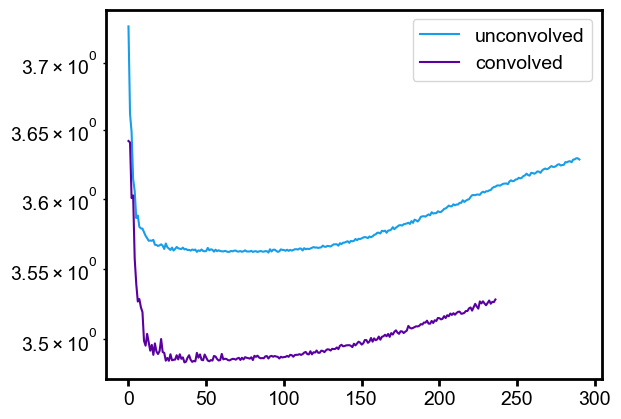

: 

In [13]:
# plot the two val losses
plt.semilogy(val_loss_unconv[1:], label='unconvolved')
plt.semilogy(val_loss_conv[1:], label='convolved')
plt.legend()

